<a href="https://colab.research.google.com/github/Georgemburu/MACHINE-LEARNING/blob/master/FRENCH_to_ENGLISH_translation_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
# http://www.manythings.org/anki/fra-eng.zip
# OVERVIEW
# (FRENCH to ENGLISH ) -> translation

In [0]:
from __future__ import division, absolute_import, print_function, unicode_literals
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import unicodedata
import re

In [61]:
path_to_zip = tf.keras.utils.get_file('fra-eng.zip',
                                      origin='http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip',
                                      extract=True)
path_to_file = os.path.dirname(path_to_zip)+'/fra.txt'
print(path_to_file)

/root/.keras/datasets/fra.txt


In [62]:
pd.read_csv(path_to_file, delimiter='\t')

,Go.,Va !
0,Hi.,Salut !
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
...,...,...
167124,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
167125,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
167126,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
167127,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [0]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s)
    if unicodedata.category(c) != 'Mn')

In [64]:
unicodedata.normalize('NFD','Si quelqu\'un qui ne connaît')

"Si quelqu'un qui ne connaît"

In [66]:
for i in 'Si quelqu\'un qui ne connaît +‣ 😋 ◌̡ k ` ¬ ^':
  c = unicodedata.category(i)
  print(i,'-->',c)

S --> Lu
i --> Ll
  --> Zs
q --> Ll
u --> Ll
e --> Ll
l --> Ll
q --> Ll
u --> Ll
' --> Po
u --> Ll
n --> Ll
  --> Zs
q --> Ll
u --> Ll
i --> Ll
  --> Zs
n --> Ll
e --> Ll
  --> Zs
c --> Ll
o --> Ll
n --> Ll
n --> Ll
a --> Ll
î --> Ll
t --> Ll
  --> Zs
+ --> Sm
‣ --> Po
  --> Zs
😋 --> So
  --> Zs
◌ --> So
̡ --> Mn
  --> Zs
k --> Ll
  --> Zs
` --> Sk
  --> Zs
¬ --> Sm
  --> Zs
^ --> Sk


In [0]:
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  # create a space between a word and the punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.rstrip().strip()
  w = '<start> ' + w + ' <end>'
  return w

In [70]:
fra_sentence = u"Il est peut-être impossible d'obtenir un Corpu"
print(preprocess_sentence(fra_sentence))

<start> il est peut etre impossible d obtenir un corpu <end>


In [0]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t') ] for l in lines[:num_examples]]
  return zip(*word_pairs)

In [72]:
en, fra = create_dataset(path_to_file,None)
print(en[-1])
print(fra[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> il est peut etre impossible d obtenir un corpus completement denue de fautes , etant donnee la nature de ce type d entreprise collaborative . cependant , si nous encourageons les membres a produire des phrases dans leurs propres langues plutot que d experimenter dans les langues qu ils apprennent , nous pourrions etre en mesure de reduire les erreurs . <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters=''
  )
  # fit vocabulary to the Tokenizer
  lang_tokenizer.fit_on_texts(lang)
  # tokenize
  tensors = lang_tokenizer.texts_to_sequences(lang)
  # Pad the tokens
  tensors = tf.keras.preprocessing.sequence.pad_sequences(tensors, padding='post')
  return tensors, lang_tokenizer


In [0]:
def load_dataset(path,num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path,num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file,num_examples)
# calculate the max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [87]:
print('max_length_targ',max_length_targ)
print('max_length_inp',max_length_inp)

max_length_targ 10
max_length_inp 17


In [88]:
# creating training and validation set
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,target_tensor)
# show length
print([len(l) for l in [input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val]])

[22500, 7500, 22500, 7500]


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t !=0:
      print(t, '-----> ', lang.index_word[t])

In [92]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----->  <start>
115 ----->  soyez
3132 ----->  justes
12 ----->  !
2 ----->  <end>

Target Language; index to word mapping
1 ----->  <start>
36 ----->  be
553 ----->  fair
3 ----->  .
2 ----->  <end>


In [0]:
# create a tf.data Dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1


dataset_TRAIN = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset_TRAIN = dataset_TRAIN.batch(BATCH_SIZE, drop_remainder=True)
# dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))

In [97]:
example_input_batch, example_target_batch = next(iter(dataset_TRAIN))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 17]), TensorShape([64, 10]))

In [98]:
# Write the encoder decoder
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights


decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)
Decoder output shape: (batch_size, vocab size) (64, 4442)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real,pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)
  

In [115]:
matx = np.array([[3,0,3],[0,3,0]])
matx = tf.math.equal(matx,3)
matx

<tf.Tensor: id=649, shape=(2, 3), dtype=bool, numpy=
array([[ True, False,  True],
       [False,  True, False]])>

In [116]:
matx = tf.math.logical_not(matx)
matx

<tf.Tensor: id=650, shape=(2, 3), dtype=bool, numpy=
array([[False,  True, False],
       [ True, False,  True]])>

In [117]:
tf.cast(matx,dtype='float32')

<tf.Tensor: id=651, shape=(2, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [1., 0., 1.]], dtype=float32)>

In [0]:
# CHECKPOINTS(OBJECT-bASED sAVING)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
# Training
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1,targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden,_ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:,t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:,t],1)

  batch_loss = (loss/int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [0]:
import time

In [135]:
EPOCHS = 10
for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in  enumerate(dataset_TRAIN.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if(batch % 100 == 0):
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving checkpoints
  if (epoch +1) %2==0:
    checkpoint.save(file_prefix= checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.7046
Epoch 1 Batch 100 Loss 2.2922
Epoch 1 Batch 200 Loss 1.9275
Epoch 1 Batch 300 Loss 1.6391
Epoch 1 Loss 2.1140
Time taken for 1 epoch 25.72206950187683 sec

Epoch 2 Batch 0 Loss 1.6327
Epoch 2 Batch 100 Loss 1.5819
Epoch 2 Batch 200 Loss 1.3853
Epoch 2 Batch 300 Loss 1.2316
Epoch 2 Loss 1.4015
Time taken for 1 epoch 26.138407468795776 sec

Epoch 3 Batch 0 Loss 1.0482
Epoch 3 Batch 100 Loss 1.1068
Epoch 3 Batch 200 Loss 0.8849
Epoch 3 Batch 300 Loss 0.8987
Epoch 3 Loss 0.9706
Time taken for 1 epoch 24.94402837753296 sec

Epoch 4 Batch 0 Loss 0.6930
Epoch 4 Batch 100 Loss 0.7305
Epoch 4 Batch 200 Loss 0.6966
Epoch 4 Batch 300 Loss 0.5500
Epoch 4 Loss 0.6473
Time taken for 1 epoch 25.052005529403687 sec

Epoch 5 Batch 0 Loss 0.4496
Epoch 5 Batch 100 Loss 0.4481
Epoch 5 Batch 200 Loss 0.3763
Epoch 5 Batch 300 Loss 0.4231
Epoch 5 Loss 0.4299
Time taken for 1 epoch 24.6175217628479 sec

Epoch 6 Batch 0 Loss 0.2658
Epoch 6 Batch 100 Loss 0.3238
Epoch 6 Batch 200 Los

In [0]:
# TRANSLATE
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in str(sentence).split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot


In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))


In [139]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Input: <start> je suis un bon garcon <end>
Predicted translation: i m a good boy . <end> 


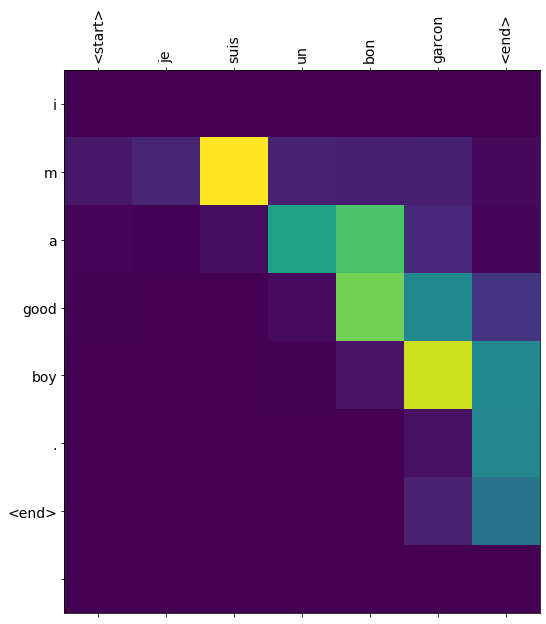

In [155]:
translate(u'je suis un bon garçon')
